In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers, regularizers

# Initializing

In [2]:
def plot_history(history, val=True):
	plt.figure(figsize=(20, 4))
	plt.subplot(1, 2, 1)
	plt.plot(history['acc'])
	if val: plt.plot(history['val_acc'])
	plt.xlabel("epochs")
	plt.ylabel("acc")
	if val: plt.legend(["acc", "val_acc"])
	plt.subplot(1, 2, 2)
	plt.plot(history['loss'])
	if val: plt.plot(history['val_loss'])
	plt.xlabel("epochs")
	plt.ylabel("loss")
	if val: plt.legend(["loss", "val_loss"])
	plt.show()
	if val:
		print(f"""
acc      : {round(history['acc'][-1], 3)}
val_acc  : {round(history['val_acc'][-1], 3)}
loss     : {round(history['loss'][-1], 3)}
val_loss : {round(history['val_loss'][-1], 3)}
	""")
	else:
		print(f"""
acc      : {round(history['acc'][-1], 3)}
loss     : {round(history['loss'][-1], 3)}
	""")

 
def process_data(dataset_url, get_maps=False, scale=True):
	# FETCHING THE DATASET
	dataset = np.load(dataset_url)
	x_train, x_test, y_train, y_test = dataset['x_train'], dataset['x_test'], dataset['y_train'], dataset['y_test']
	x = np.concatenate([x_train, x_test])
	y = np.concatenate([y_train, y_test])
	# SHUFFLING THE DATASET
	r = np.random.permutation(x.shape[0])
	x = x[r]
	y = y[r]
	# CREATING 2D ARRAY OF MAP
	pic_x = np.apply_along_axis(
		lambda x: x.tolist().index(1),
		3,
		x,
	)
		
	# GETTING POSSIBLE DIRECTIONS AND POSSITIONS OF HEAD AND FOOD
	def get_possition_dirs(x):
		food_x, food_y = np.where(x == 2)[1], np.where(x == 2)[0]
		head_x, head_y = np.where(x == 3)[1], np.where(x == 3)[0]

		possible_dirs = [
			int(x[head_y-1, head_x] == 0 or x[head_y-1, head_x] == 2),
			int(x[head_y, head_x-1] == 0 or x[head_y, head_x-1] == 2),
			int(x[head_y+1, head_x] == 0 or x[head_y+1, head_x] == 2),
			int(x[head_y, head_x+1] == 0 or x[head_y, head_x+1] == 2),
		]
		possitions = [head_x[0], head_y[0], food_x[0], food_y[0]]
		if scale:
			possitions[0] /= 27
			possitions[1] /= 30
			possitions[2] /= 27
			possitions[3] /= 30
		return possitions, possible_dirs
	possitions = []
	possible_dirs = []
	for i in pic_x:
		a = get_possition_dirs(i)
		possitions.append(a[0])
		possible_dirs.append(a[1])
	possitions = np.array(possitions)
	possible_dirs = np.array(possible_dirs)

	if get_maps:
		# GETTING MAPS
		maps = np.where(pic_x == 1, 1, 0)
		maps = maps.reshape(maps.shape + (1,))
		return maps, possitions, possible_dirs, y
	else:
		return possitions, possible_dirs, y

def proceed_model(model, inputs, outputs, model_name, epochs=10000, verbose=0, patience=200, test_size=0.1, include_callbacks=True, extract_valid=False, callback_monitor='acc'):

    if type(inputs) == list:
        r = np.random.permutation(outputs.shape[0])
        for i in range(len(inputs)):
            inputs[i] = inputs[i][r]
        outputs = outputs[r]

        border_index = int(len(outputs)*(1-test_size))
        if model_name == "fixed":
            x_train = [inputs[0][:border_index], inputs[1][:border_index]]
            x_test = [inputs[0][border_index:], inputs[1][border_index:]]
        else:
            x_train = [inputs[0][:border_index], inputs[1][:border_index], inputs[2][:border_index]]
            x_test = [inputs[0][border_index:], inputs[1][border_index:], inputs[2][border_index:]]
        y_train = outputs[:border_index]
        y_test = outputs[border_index:]
    else:
        from sklearn.model_selection import train_test_split
        x_train, x_test, y_train, y_test = train_test_split(inputs, outputs, test_size=test_size)

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])
    if include_callbacks:
        my_callbacks = [
                    callbacks.EarlyStopping(patience=patience,monitor = callback_monitor,min_delta = 0.01,mode = 'max',),
                    callbacks.ModelCheckpoint(filepath=models_url + model_name + '.h5',save_weights_only=True,frequency='epoch',save_freq='epoch',save_best_only=True,monitor='acc',mode='max',)
                ]
    else:
        my_callbacks = None
    with tf.device('GPU:0'):
        if not extract_valid:
            if type(inputs) == list:
                for i in range(len(x_train)):
                    x_train[i] = np.concatenate([x_train[i], x_test[i]])
            else: x_train = np.concatenate([x_train, x_test])
            y_train = np.concatenate([y_train, y_test])
        history = model.fit(x_train, y_train, epochs=epochs, verbose=verbose, callbacks=my_callbacks, validation_split=test_size)
    if include_callbacks:
        with open(models_url + model_name + ".json", "w") as f:
            f.write(model.to_json())
    plot_history(history.history, val=not extract_valid)

    # EVALUTAING THE MODEL
    if include_callbacks:
        with open(models_url + model_name + ".json", "r") as f:
            loaded_model = models.model_from_json(f.read())
        loaded_model.load_weights(models_url + model_name + ".h5")
    else: loaded_model = model

    loaded_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])
    loaded_model.evaluate(x_test, y_test)

In [3]:
"/content/drive/MyDrive/Cloud/Temp Files/"
fixed_dataset_url = "/content/drive/MyDrive/Cloud/Temp Files//fixed_dataset.npz"
random_dataset_url = "/content/drive/MyDrive/Cloud/Temp Files//random_dataset.npz"
binary_map_url = "/content/drive/MyDrive/Cloud/Temp Files//binary_map.json"
models_url = "/content/drive/MyDrive/Cloud/Temp Files//"
finalized_fixed_model_url = "/content/drive/MyDrive/Cloud/Temp Files/Finalized/fixed_model"
finalized_random_model_url = "/content/drive/MyDrive/Cloud/Temp Files/Finalized/random_model"

# GETTING THE ALREADY TRAINED MODELS
if True:
    with open(finalized_fixed_model_url + ".json") as f:
        loaded_finalized_fixed_model = models.model_from_json(f.read())
    loaded_finalized_fixed_model.load_weights(finalized_fixed_model_url + ".h5")

    with open(finalized_random_model_url + ".json") as f:
        loaded_finalized_random_model = models.model_from_json(f.read())
    loaded_finalized_random_model.load_weights(finalized_random_model_url + ".h5")

    loaded_finalized_fixed_model.compile("adam", "sparse_categorical_crossentropy", ['acc'])
    loaded_finalized_random_model.compile("adam", "sparse_categorical_crossentropy", ['acc'])

# Random

In [ ]:
random_maps, random_poss, random_dirs, random_y = process_data(random_dataset_url, get_maps=True, scale=True)

## Using Tranfer

In [ ]:
loaded_finalized_random_model.evaluate([random_maps, random_poss, random_dirs], random_y)

In [ ]:
transfer_model = loaded_finalized_fixed_model
transfer_model.trainable = True


input_maps = layers.Input(shape=(31, 28, 1), name="input_maps")
input_poss = layers.Input(shape=(4,), name="input_poss")
input_dirs = layers.Input(shape=(4,), name="input_dirs")
input_tsfr = transfer_model([input_poss, input_dirs])

model_maps = models.Sequential([

    # maps MODEL
    layers.Conv2D(4, 2, padding='SAME', activation='linear'),
    layers.Conv2D(8, 2, padding='SAME', activation='tanh'),
    layers.AveragePooling2D(2),
    layers.MaxPooling2D(2),
    layers.Flatten(),
    layers.Dropout(0.3),
    layers.Dense(80, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(400, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1600, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(800, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(20, activation='relu'),
    # ====

])(input_maps)
model_poss = models.Sequential([

    # poss MODEL
    layers.Dense(20, activation="relu"),
    layers.Dense(400, activation="relu"),
    layers.Dropout(0.4),
    layers.Dense(20, activation="relu"),
    # ====

])(input_poss)
model_dirs = models.Sequential([

    # dirs MODEL
    layers.Dense(20, activation="relu"),
    layers.Dense(400, activation="relu"),
    layers.Dropout(0.4),
    layers.Dense(20, activation="relu"),
    # ====

])(input_dirs)
model_tsfr = models.Sequential([

    #  tsfr MODEL
    layers.Dense(20, activation="relu"),
    layers.Dense(400, activation="relu"),
    layers.Dropout(0.4),
    layers.Dense(20, activation="relu"),
    # ====

])(input_tsfr)

output_maps = layers.Dense(40, activation='relu', name="output_maps")(model_maps)
output_poss = layers.Dense(10, activation='relu', name="output_poss")(model_poss)
output_dirs = layers.Dense(10, activation='relu', name="output_dirs")(model_dirs)
output_tsfr = layers.Dense(10, activation='relu', name="output_tsfr")(model_tsfr)

input_conc = layers.Concatenate()([output_maps, output_poss, output_dirs, output_tsfr])
model_conc = models.Sequential([

    #  conc MODEL
    layers.Dense(80, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.4),
    layers.Dense(400, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.4),
    layers.Dense(800, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.5),
    layers.Dense(1600, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.4),
    layers.Dense(80, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.2),
    layers.Dense(20, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    # ====

])(input_conc)
output_conc = layers.Dense(4, activation='sigmoid')(model_conc)

random_model = models.Model(inputs=[input_maps, input_poss, input_dirs], outputs=output_conc)
# random_model.summary()
proceed_model(
    model=random_model,
    model_name="random_model",
    inputs=[random_maps, random_poss, random_dirs],
    outputs=random_y,
    epochs=10000,
    patience=50,
    verbose=0,
    test_size=0.2,
    plot_val=False,
)

In [ ]:
"""
transfer-random: 0.922 0.9298
transfer-fixed:  0.92  0.8977
"""

## Using Functional

In [ ]:
input_maps = layers.Input(shape=(31, 28, 1), name="input_maps")
input_poss = layers.Input(shape=(4,), name="input_poss")
input_dirs = layers.Input(shape=(4,), name="input_dirs")

model_maps = models.Sequential([
                                
    # MAPS
    layers.Conv2D(4, 2, padding='SAME', activation='linear'),
    layers.Conv2D(8, 2, padding='SAME', activation='tanh'),
    layers.AveragePooling2D(2),
    layers.MaxPooling2D(2),
    layers.Flatten(),
    layers.Dense(80, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(400, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1600, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(800, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(20, activation='relu'),

], name="model_maps")(input_maps)
model_poss = models.Sequential([
                                
    # POSS
    layers.Dense(20, activation="relu"),
    layers.Dense(400, activation="relu"),
    layers.Dropout(0.4),
    layers.Dense(20, activation="relu"),

], name="model_poss")(input_poss)
model_dirs = models.Sequential([
                                
    # DIRS
    layers.Dense(20, activation="relu"),
    layers.Dense(400, activation="relu"),
    layers.Dropout(0.4),
    layers.Dense(20, activation="relu"),

], name="model_dirs")(input_dirs)

output_maps = layers.Dense(40, activation='relu', name="output_maps")(model_maps)
output_poss = layers.Dense(10, activation='relu', name="output_poss")(model_poss)
output_dirs = layers.Dense(10, activation='relu', name="output_dirs")(model_dirs)

input_conc = layers.Concatenate(name="input_conc")([output_maps, output_poss, output_dirs])
model_conc = models.Sequential([

    # CONC
    layers.Dense(80, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(400, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(800, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1600, activation='relu'),
    layers.Dense(2400, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(4000, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(400, activation='relu'),
    layers.Dense(80, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(20, activation='relu'),
], name="model_conc")(input_conc)
output_conc = layers.Dense(4, activation='softmax', name="output_conc")(model_conc)

random_model = models.Model(inputs=[input_maps, input_poss, input_dirs], outputs=output_conc, name="random_model")
proceed_model(
    model=random_model,
    model_name="random_model",
    inputs=[random_maps, random_poss, random_dirs],
    outputs=random_y,
    epochs=10000,
    patience=1000,
    verbose=0,
    test_size=0.2,
    plot_val=False,
)

In [ ]:
random_model.evaluate([random_maps, random_poss, random_dirs], random_y)

# Fixed

In [ ]:
fixed_poss, fixed_dirs, fixed_y = process_data(fixed_dataset_url, get_maps=False, scale=True)

In [ ]:
# POSSITIONS
input_poss = layers.Input(shape=(4,))
model_poss = models.Sequential([
	layers.Dense(20, activation='relu'),
	# layers.Dense(200, activation='relu'),
	layers.Dense(80, activation='relu'),
	# layers.Dropout(0.3),
	layers.Dense(400, activation='relu'),
])(input_poss)
output_poss = layers.Dense(10, activation='relu')(model_poss)

# POSSIBLE DIRECTIONS
input_dirs = layers.Input(shape=(4,))
model_dirs = models.Sequential([
	layers.Dense(20, activation='relu'),
	# layers.Dense(200, activation='relu'),
	layers.Dense(80, activation='relu'),
	# layers.Dropout(0.3),
	layers.Dense(400, activation='relu'),
])(input_dirs)
output_dirs = layers.Dense(10)(model_dirs)

# CONCATENATED LAYERS
input = layers.Concatenate()([
	output_poss,
	output_dirs,
])
model_concat = models.Sequential([
	layers.Dense(80, activation='relu'),
	# layers.Dense(400, activation='relu'),
	# layers.Dense(1600, activation='relu'),
	layers.Dense(200, activation='relu'),
	layers.Dropout(0.3),
	layers.Dense(800, activation='relu'),
	layers.Dropout(0.3),
	layers.Dense(80, activation='relu'),
])(input)
output = layers.Dense(4, activation='sigmoid')(model_concat)

fixed_model = models.Model(inputs=[input_poss, input_dirs], outputs=output)

fixed_model.summary()

proceed_model(
	  model=fixed_model,
	  model_name="fixed_model",
	  inputs=[fixed_poss, fixed_dirs],
	  outputs=fixed_y,
	  epochs=20,
	  verbose=1,
)

In [ ]:
"""
0.985, 0.987, 0.9888
0.998, 0.985, 0.9975
0.995, 0.987, 0.9968
0.997, 0.991, 0.9972

"""

# New Random Data Analytics

## Preprocessing

In [40]:
drive_url = "/content/drive/MyDrive/Cloud/Temp Files/"

# FETCHING DATASET FILE
with open(drive_url + "latest_dataset.txt", "r") as f:
    content1 = f.read().split("\n")[1:]
    maps1 = []
    dirs1 = []
    for line in content1:
        maps1.append([int(i) for i in line[:-1].strip("[]").split(", ")])
        dirs1.append(['u', 'l', 'd', 'r'].index(line[-1]))
with open(drive_url + "new_latest_dataset.txt", "r") as f:
    content2 = f.read().split("\n")[1:]
    maps2 = []
    dirs2 = []
    for line in content2:
        maps2.append( [int(i) for i in line[:-2].strip("[]").split(",")] )
        dirs2.append(int(line[-1]))

# maps = np.array(maps2).astype("float32")
# dirs = np.array(dirs2).astype("int")
maps = np.concatenate([maps1, maps2]).astype("float32")
dirs = np.concatenate([dirs1, dirs2]).astype("int")

# SHUFFLING THE DATASET
r = np.random.permutation(maps.shape[0])
maps = maps[r]
dirs = dirs[r]

# GIVING ALL BODY PARTS SAME REPRESENTATION
maps = np.where(maps > 3, 4, maps)

# GETTING IMAGE MAPS
maps_img = maps.reshape(maps.shape[0], 31, 28, 1)
# GETTING POSSIBLE DIRECTIONS AND POSSITIONS OF HEAD AND FOOD
def get_possition_dirs(x):
    food_x, food_y = np.where(x == 2)[1], np.where(x == 2)[0]
    head_x, head_y = np.where(x == 3)[1], np.where(x == 3)[0]

    possible_dirs = [
        int(x[head_y-1, head_x] == 0 or x[head_y-1, head_x] == 2),
        int(x[head_y, head_x-1] == 0 or x[head_y, head_x-1] == 2),
        int(x[head_y+1, head_x] == 0 or x[head_y+1, head_x] == 2),
        int(x[head_y, head_x+1] == 0 or x[head_y, head_x+1] == 2),
    ]
    possitions = [head_x[0], head_y[0], food_x[0], food_y[0]]
    possitions[0] /= 27
    possitions[1] /= 30
    possitions[2] /= 27
    possitions[3] /= 30
    return possitions, possible_dirs
possitions = []
possible_dirs = []
for i in maps_img:
    a = get_possition_dirs(i)
    possitions.append(a[0])
    possible_dirs.append(a[1])
possitions = np.array(possitions)
possible_dirs = np.array(possible_dirs)

maps_img.shape, possitions.shape, possible_dirs.shape, dirs.shape

((10395, 31, 28, 1), (10395, 4), (10395, 4), (10395,))

[0.44444444 0.5        0.22222222 0.03333333] [0 1 1 0] 2


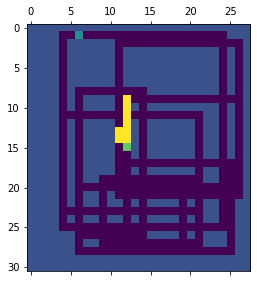

In [42]:
i = 10394
print(possitions[i], possible_dirs[i], dirs[i])
plt.matshow(maps_img[i,...,0])

## Transfer Learning

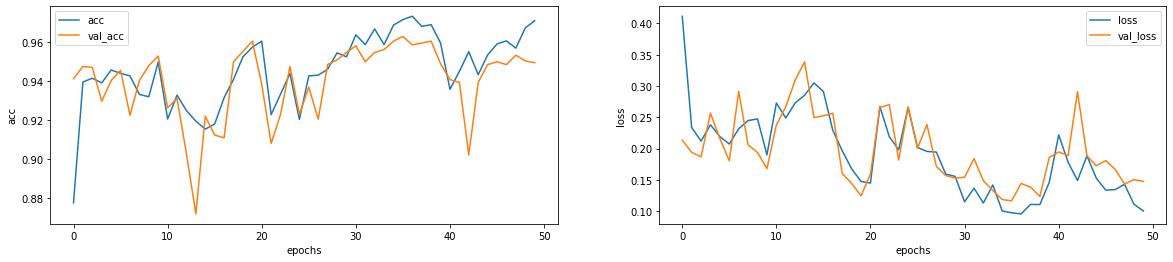


acc      : 0.971
val_acc  : 0.949
loss     : 0.1
val_loss : 0.148
	
65/65 [==============================] - 2s 12ms/step - loss: 0.1442 - acc: 0.9586


In [44]:
with open(finalized_random_model_url + ".json") as f:
    loaded_finalized_random_model = models.model_from_json(f.read())
loaded_finalized_random_model.load_weights(finalized_random_model_url + ".h5")
transfer_model = loaded_finalized_fixed_model
transfer_model.trainable = True

input_poss = layers.Input(shape=possitions.shape[1:], name="input_poss")
input_dirs = layers.Input(shape=possible_dirs.shape[1:], name="input_dirs")
input_imgs = layers.Input(shape=maps_img.shape[1:], name="input_imgs")
input_tsfr = transfer_model([input_poss, input_dirs])

model_imgs = models.Sequential([
    # ==== imgs ==== 
    layers.Conv2D(64, 3, padding='SAME', activation='relu'),
    layers.Conv2D(128, 3, padding='SAME', activation='relu'),
    layers.AveragePooling2D(2),
    layers.AveragePooling2D(2),
    layers.MaxPooling2D(2),
    layers.Flatten(),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(80, activation='relu'),
    layers.Dense(900, activation='relu'),
    layers.Dense(40, activation='relu'),
    # ==============
], name="model_imgs")(input_imgs)
model_tsfr = models.Sequential([
    # ==== tsfr ==== 
    layers.Dense(80, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(800, activation='relu'),
    layers.Dense(900, activation='relu'),
    layers.Dense(400, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(80, activation='relu'),

    layers.Dropout(0.3),
    # ==============
], name="model_tsfr")(input_tsfr)

output_imgs = layers.Dense(10, activation='relu', name="output_imgs")(model_imgs)
output_tsfr = layers.Dense(10, activation='relu', name="output_tsfr")(model_tsfr)

input_conc = layers.Concatenate(name="input_conc")([output_imgs, output_tsfr])
model_conc = models.Sequential([
    # ==== conc ==== 
    layers.Dense(80, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(400, activation='relu'),
    layers.Dense(800, activation='relu'),
    layers.Dense(900, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(80, activation='relu'),

    layers.BatchNormalization(),
    # ==============
], name="model_conc")(input_conc)
output_conc = layers.Dense(4, activation='sigmoid', name="output_conc")(model_conc)

new_random_model = models.Model(inputs=[input_imgs, input_poss, input_dirs], outputs=output_conc, name="random_model")

# new_random_model.summary()
# tf.keras.utils.plot_model(
# 	new_random_model,
# 	'ploted_img.png',
# 	show_shapes=True
# )

with tf.device('GPU:0'):
    proceed_model(
        model=new_random_model,
        inputs=[maps_img, possitions, possible_dirs],
        outputs=dirs,
        model_name='new_random_model',
        epochs=50,
        verbose=0,
        patience=100,
        test_size=0.2,
        callback_monitor='acc',
        include_callbacks=True,
        extract_valid=False
    )

In [ ]:
"""
0.97  0.953 0.9663
0.97  0.952 0.9500
0.976 0.93  0.9321
"""

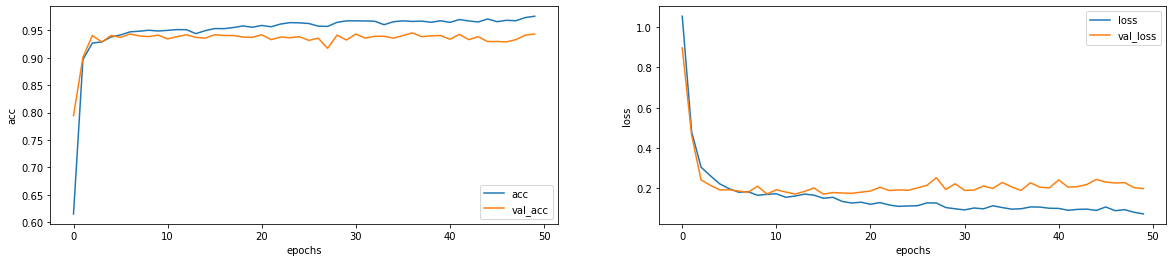


acc      : 0.975
val_acc  : 0.943
loss     : 0.073
val_loss : 0.198
	
46/46 [==============================] - 1s 4ms/step - loss: 0.1984 - acc: 0.9431


In [35]:
with open(finalized_random_model_url + ".json") as f:
    loaded_finalized_random_model = models.model_from_json(f.read())
loaded_finalized_random_model.load_weights(finalized_random_model_url + ".h5")
transfer_model = loaded_finalized_fixed_model
transfer_model.trainable = True

input_poss = layers.Input(shape=possitions.shape[1:], name="input_poss")
input_dirs = layers.Input(shape=possible_dirs.shape[1:], name="input_dirs")
input_imgs = layers.Input(shape=maps_img.shape[1:], name="input_imgs")
input_tsfr = transfer_model([input_poss, input_dirs])

model_imgs = models.Sequential([
    # ==== imgs ==== 
    layers.Flatten()
    # ==============
], name="model_imgs")(input_imgs)
model_tsfr = models.Sequential([
    # ==== tsfr ==== 
    layers.BatchNormalization(),
    layers.BatchNormalization(),
    layers.BatchNormalization(),
    # ==============
], name="model_tsfr")(input_tsfr)

output_imgs = layers.Dense(10, activation='relu', name="output_imgs")(model_imgs)
output_tsfr = layers.Dense(10, activation='relu', name="output_tsfr")(model_tsfr)

input_conc = layers.Concatenate(name="input_conc")([output_imgs, output_tsfr])
model_conc = models.Sequential([
    # ==== conc ==== 
    # layers.Dense(80, activation='relu'),
    # layers.Dense(400, activation='relu'),
    # layers.Dense(900, activation='relu'),
    # layers.Dense(20, activation='relu'),
    # ==============
], name="model_conc")(input_conc)
output_conc = layers.Dense(4, activation='sigmoid', name="output_conc")(model_conc)

new_random_model = models.Model(inputs=[input_imgs, input_poss, input_dirs], outputs=output_conc, name="random_model")

# new_random_model.summary()
# tf.keras.utils.plot_model(
# 	new_random_model,
# 	'ploted_img.png',
# 	show_shapes=True
# )

with tf.device('GPU:0'):
    proceed_model(
        model=new_random_model,
        inputs=[maps_img, possitions, possible_dirs],
        outputs=dirs,
        model_name='new_random_model',
        epochs=50,
        verbose=0,
        patience=100,
        test_size=0.2,
        callback_monitor='acc',
        include_callbacks=True,
        extract_valid=False
    )

In [ ]:
0.975
0.943

# Using Previous Random Method

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_imgs (InputLayer)        [(None, 31, 28, 1)]  0           []                               
                                                                                                  
 input_poss (InputLayer)        [(None, 4)]          0           []                               
                                                                                                  
 input_dirs (InputLayer)        [(None, 4)]          0           []                               
                                                                                                  
 model_imgs (Sequential)        (None, 80)           555256      ['input_imgs[0][0]']             
                                                                                              

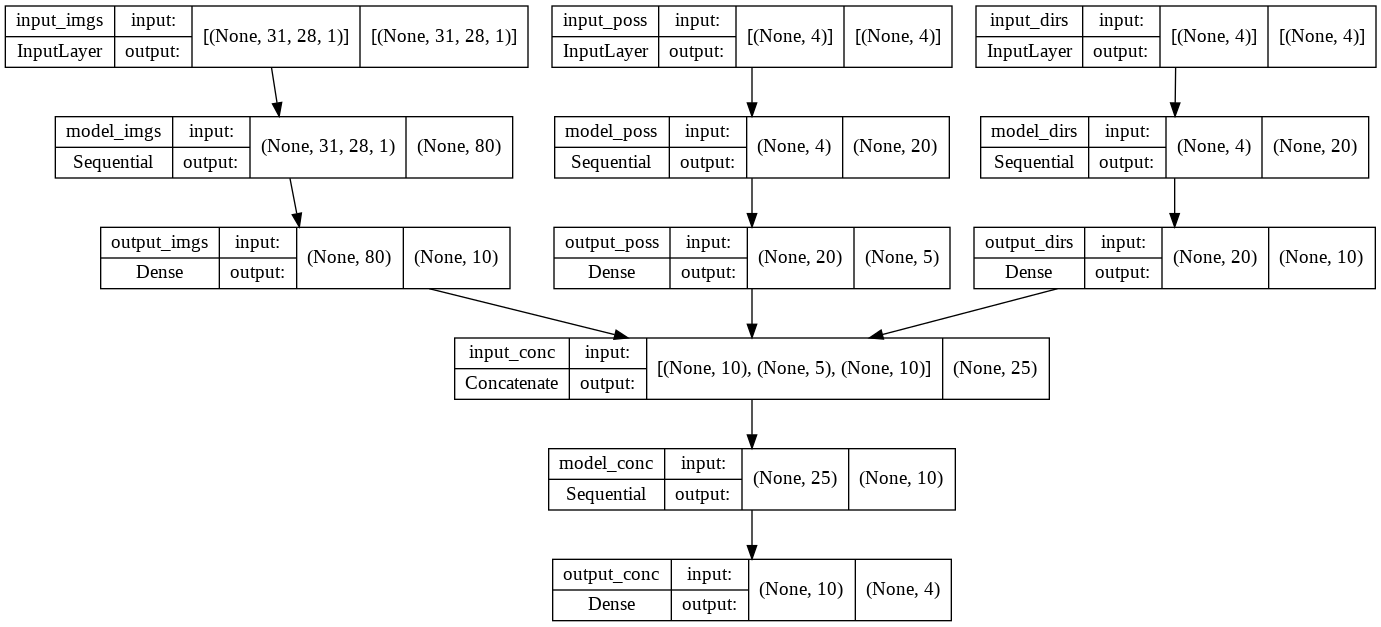

In [5]:
input_imgs = layers.Input(shape=maps_img.shape[1:], name="input_imgs")
input_poss = layers.Input(shape=possitions.shape[1:], name="input_poss")
input_dirs = layers.Input(shape=possible_dirs.shape[1:], name="input_dirs")

model_imgs = models.Sequential([
    # ==== imgs ==== 
    layers.Conv2D(64, 3, padding='SAME', activation='relu'),
    layers.Conv2D(128, 3, padding='SAME', activation='relu'),
    layers.AveragePooling2D(2),
    layers.AveragePooling2D(2),
    layers.MaxPooling2D(2),
    layers.Flatten(),
    layers.Dense(80, activation='relu'),
    layers.Dense(400, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(800, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(40, activation='relu'),
    layers.Dense(80, activation='relu'),
    # ==============
], name="model_imgs")(input_imgs)
model_poss = models.Sequential([
    # ==== poss ==== 
    layers.Dense(40, activation="relu"),
    layers.Dense(800, activation="relu"),
    layers.Dropout(0.4),
    layers.Dense(20, activation="relu"),
    # ==============
], name="model_poss")(input_poss)
model_dirs = models.Sequential([
    # ==== dirs ==== 
    layers.Dense(40, activation="relu"),
    layers.Dense(800, activation="relu"),
    layers.Dropout(0.4),
    layers.Dense(20, activation="relu"),
    # ==============
], name="model_dirs")(input_dirs)

output_imgs = layers.Dense(10, activation='relu', name="output_imgs")(model_imgs)
output_poss = layers.Dense(5, activation='relu', name="output_poss")(model_poss)
output_dirs = layers.Dense(10, activation='relu', name="output_dirs")(model_dirs)

input_conc = layers.Concatenate(name="input_conc")([output_imgs, output_poss, output_dirs])
model_conc = models.Sequential([
    # ==== conc ==== 
    layers.Dense(20, activation='relu'),
    layers.Dense(100, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(400, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(800, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(20, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(100, activation='relu'),
    layers.Dense(10, activation='relu'),
    # ==============
], name="model_conc")(input_conc)
output_conc = layers.Dense(4, activation='sigmoid', name="output_conc")(model_conc)

# new_random_model = models.Model(inputs=[input_imgs, input_poss, input_dirs], outputs=output_conc)
# new_random_model.summary()
# tf.keras.utils.plot_model(
# 	new_random_model,
# 	'ploted_img.png',
# 	show_shapes=True
# )

# with tf.device('GPU:0'):
#     proceed_model(
#         model=new_random_model,
#         inputs=[maps_img, possitions, possible_dirs],
#         outputs=dirs,
#         model_name='new_random_model',
#         epochs=1000,
#         verbose=0,
#         patience=0,
#         test_size=0.2,
#         callback_monitor='acc',
#         include_callbacks=True,
#         extract_valid=False
#     )


In [ ]:
# 98, 93

## Using Maps image

In [ ]:
new_random_model = models.Sequential([
    layers.Input(shape=maps_img.shape[1:]),
    layers.Conv2D(32, 3, padding='SAME', activation='relu'),
    layers.MaxPooling2D(2),
    layers.Flatten(),
    layers.Dense(4, activation='sigmoid'),
])
proceed_model(
    model=new_random_model,
    inputs=maps_img,
    outputs=dirs,
    model_name='new_random_model',
    epochs=50,
    verbose=0,
    patience=200,
    test_size=0.2,
    plot_val=False,
    include_callbacks=True,
)

In [ ]:
"""
0.977  0.8349


"""

## Using Flat Map

In [ ]:
new_random_model = models.Sequential([
    layers.Input(shape=maps.shape[1:]),
    layers.Dense(80, activation='relu'),
    layers.Dense(800, activation='relu'),
    layers.Dense(1600, activation='relu'),
    layers.Dense(2400, activation='relu'),
    layers.Dense(1000, activation='relu'),
    layers.Dense(20, activation='relu'),
    layers.Dense(4, activation='sigmoid'),
])
proceed_model(
    model=new_random_model,
    inputs=maps,
    outputs=dirs,
    model_name='new_random_model',
    epochs=100,
    verbose=0,
    patience=200,
    test_size=0.2,
    plot_val=False,
    include_callbacks=True,
)